<a href="https://colab.research.google.com/github/DeadlyPancakes45/Nucleus_detection/blob/main/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#imports
import os
import zipfile


In [8]:
from google.colab import files
files.upload()  # This will prompt you to upload the file.


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tanmay2027","key":"1c336c4a9e7d7a91273a2b136d088223"}'}

In [9]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/


In [10]:
!chmod 600 ~/.kaggle/kaggle.json

In [11]:
!kaggle competitions download -c data-science-bowl-2018

 99% 353M/358M [00:02<00:00, 201MB/s]
100% 358M/358M [00:02<00:00, 183MB/s]


In [16]:
!ls -lh


total 359M
-rw-r--r-- 1 root root 359M Dec 11  2019  data-science-bowl-2018.zip
-rw-r--r-- 1 root root   66 Feb  7 15:01 'kaggle-2 (1).json'
-rw-r--r-- 1 root root   66 Feb  7 14:59  kaggle-2.json
drwxr-xr-x 1 root root 4.0K Feb  5 14:21  sample_data


In [12]:
!unzip data-science-bowl-2018.zip -d dsb2018/

Archive:  data-science-bowl-2018.zip
  inflating: dsb2018/stage1_sample_submission.csv.zip  
  inflating: dsb2018/stage1_solution.csv.zip  
  inflating: dsb2018/stage1_test.zip  
  inflating: dsb2018/stage1_train.zip  
  inflating: dsb2018/stage1_train_labels.csv.zip  
  inflating: dsb2018/stage2_sample_submission_final.csv.zip  
  inflating: dsb2018/stage2_test_final.zip  


In [14]:
!unzip dsb2018/stage1_train.zip -d stage1_train/
!unzip dsb2018/stage1_test.zip -d stage1_test/

Streaming output truncated to the last 5000 lines.
  inflating: stage1_train/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/d86ee01921b1c9ed23c342952253682060512483c39c8b7b5c6d8350f6df2568.png  
  inflating: stage1_train/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/d8b76279ad8f2e101bb8c5ca95229b6532903eea035ef945dd4a21356d49dead.png  
  inflating: stage1_train/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/dc05f946c096c5fcc147024843f21c06c3a94af25d4f37b498ea937953b806fe.png  
  inflating: stage1_train/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/e0fd1c4e98bb470bea315e7d8f74396450fe93e93f68e1f8a3443b2b397c8640.png  
  inflating: stage1_train/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/e4b6643cafde8ac789b63f7b1a023773960dbe63489963985033619fde052dc9.png  
  inflating: stage1_train/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/e7e793a1e178

In [15]:
import os

train_dir = "stage1_train/"
test_dir = "stage1_test/"

# List the first 5 patient folders
train_patients = os.listdir(train_dir)[:5]
print("Sample training patient folders:", train_patients)

# List images inside the first patient folder
if train_patients:
    image_path = os.path.join(train_dir, train_patients[0], "images")
    images = os.listdir(image_path)
    print("Images inside the first patient folder:", images)

Sample training patient folders: ['40b00d701695d8ea5d59f95ac39e18004040c96d17fbc1a539317c674eca084b', 'a3a65623e079af7988b0c1cf1e54041003c6d730c91ecf200b71c47b93a67ed6', '49edc2f7715100fb0390916e52b3fd11a921f02e59509dc987f67840a36250fc', '8ecdb93582b2d5270457b36651b62776256ade3aaa2d7432ae65c14f07432d49', '08151b19806eebd58e5acec7e138dbfbb1761f41a1ab9620466584ecc7d5fada']
Images inside the first patient folder: ['40b00d701695d8ea5d59f95ac39e18004040c96d17fbc1a539317c674eca084b.png']


Displaying: stage1_train/40b00d701695d8ea5d59f95ac39e18004040c96d17fbc1a539317c674eca084b/images/40b00d701695d8ea5d59f95ac39e18004040c96d17fbc1a539317c674eca084b.png


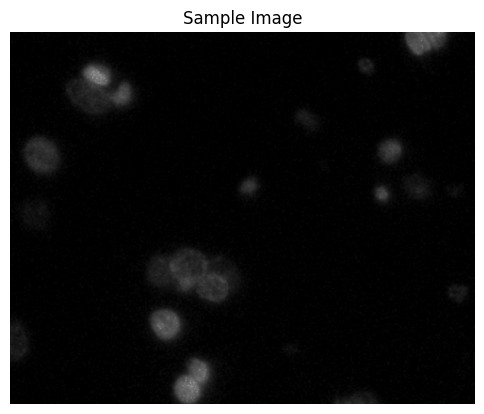

In [16]:
import cv2
import matplotlib.pyplot as plt

def display_image(image_path):
    """Loads and displays an image."""
    image = cv2.imread(image_path)
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        plt.figure(figsize=(6, 6))
        plt.imshow(image)
        plt.axis("off")
        plt.title("Sample Image")
        plt.show()
    else:
        print("Error: Unable to load image.")

# Pick the first image from the dataset and display it
sample_image_path = os.path.join(train_dir, train_patients[0], "images", train_patients[0] + ".png")
print("Displaying:", sample_image_path)
display_image(sample_image_path)

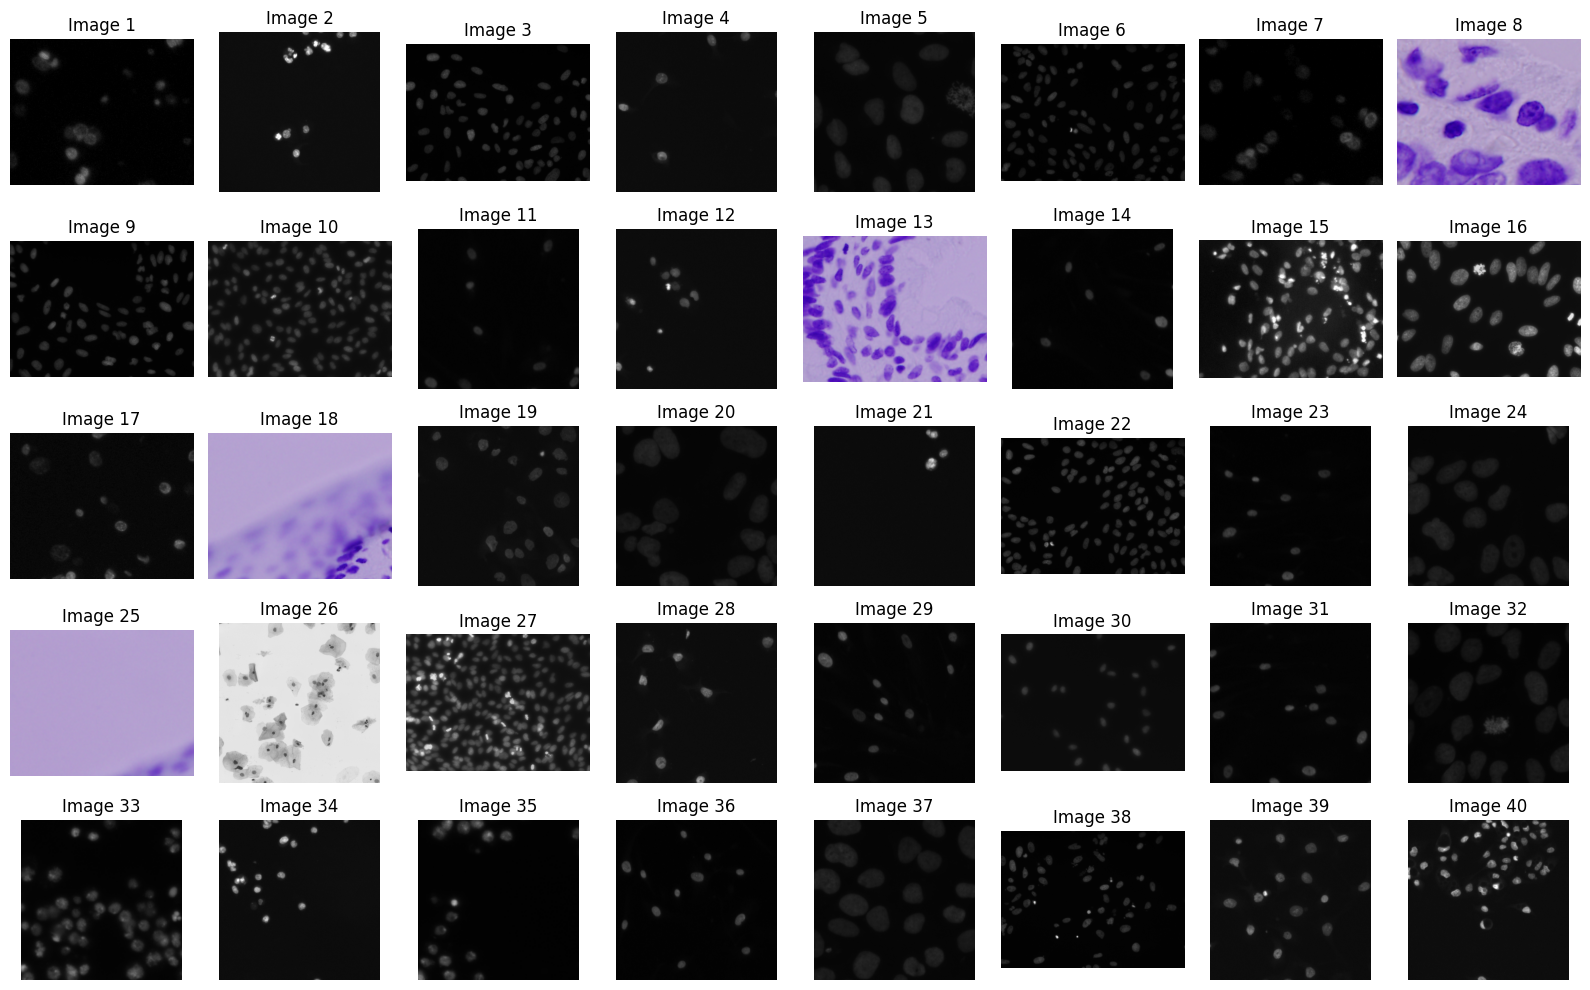

In [17]:
import os
import cv2
import math
import matplotlib.pyplot as plt
def display_multiple_images(image_paths, max_cols=8, max_images=40):
    """Dynamically display multiple images in a grid."""
    num_images = min(len(image_paths), max_images)
    rows = math.ceil(num_images / max_cols)
    cols = min(num_images, max_cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.ravel()
    for i in range(rows * cols):
        if i < num_images:
            image = cv2.imread(image_paths[i])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            axes[i].imshow(image)
            axes[i].axis("off")
            axes[i].set_title(f"Image {i+1}")
        else:
            axes[i].axis("off")
    plt.tight_layout()
    plt.show()


train_dir = "stage1_train"
train_patients = os.listdir(train_dir)
sample_images = [
    os.path.join(train_dir, patient, "images", patient + ".png")
    for patient in train_patients if os.path.exists(os.path.join(train_dir, patient, "images", patient + ".png"))
]
display_multiple_images(sample_images, max_cols=8, max_images=40)

In [22]:
import os

dataset_path = os.path.join(os.getcwd(), "data_science_bowl_2018/")
print("Dataset Path:", dataset_path)

Dataset Path: /content/data_science_bowl_2018/


In [26]:
import os

dataset_path = "/content/stage1_train/"

if os.path.exists(dataset_path):
    print("✅ Dataset found!")
    print("Number of image folders:", len(os.listdir(dataset_path)))
else:
    print("❌ Dataset path is incorrect. Check the directory.")

✅ Dataset found!
Number of image folders: 670


In [28]:
!mkdir -p /content/data_science_bowl_2018
!mv /content/stage1_train /content/data_science_bowl_2018/
!mv /content/stage1_test /content/data_science_bowl_2018/
!mv /content/dsb2018 /content/data_science_bowl_2018/
!mv /content/data-science-bowl-2018.zip /content/data_science_bowl_2018/

In [29]:
import os

dataset_path = "/content/data_science_bowl_2018/"

if os.path.exists(dataset_path):
    print("✅ Dataset folder exists!")
    print("Contents of dataset folder:", os.listdir(dataset_path))
else:
    print("❌ Dataset folder not found. Check the directory.")

✅ Dataset folder exists!
Contents of dataset folder: ['stage1_test', 'stage1_train', 'dsb2018', 'data-science-bowl-2018.zip']


In [30]:
train_path = "/content/data_science_bowl_2018/stage1_train/"
test_path = "/content/data_science_bowl_2018/stage1_test/"
dsb_path = "/content/data_science_bowl_2018/dsb2018/"
zip_file = "/content/data_science_bowl_2018/data-science-bowl-2018.zip"

print("Train Path:", train_path)
print("Test Path:", test_path)
print("Other Files:", dsb_path, zip_file)

Train Path: /content/data_science_bowl_2018/stage1_train/
Test Path: /content/data_science_bowl_2018/stage1_test/
Other Files: /content/data_science_bowl_2018/dsb2018/ /content/data_science_bowl_2018/data-science-bowl-2018.zip


In [32]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob
example_folder = os.path.join(dataset_path, os.listdir(dataset_path)[0])
image_path = glob(os.path.join(example_folder, "images", "*.png"))[0]
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask_paths = glob(os.path.join(example_folder, "masks", "*.png"))
masks = [cv2.imread(mask, cv2.IMREAD_GRAYSCALE) for mask in mask_paths]
combined_mask = np.zeros_like(masks[0])
for mask in masks:
    combined_mask = np.maximum(combined_mask, mask)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(combined_mask, cmap="gray")
plt.title("Combined Mask")
plt.axis("off")

plt.show()

IndexError: list index out of range